In [3]:

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers.core import Dropout, Lambda
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from google.colab import drive

drive.mount('/content/drive')

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/content/drive/My Drive/cs4990-fall2019-assignment-3/training_images/training_images'
VALIDATION_PATH = '/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_images/validation_images'
TEST_PATH = '/content/drive/My Drive/cs4990-fall2019-assignment-3/testing_images/testing_images'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Rename validation images and masks to use in training data
# name = 1501
# for filename in os.listdir('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_images/validation_images'):
#   os.rename('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_images/validation_images' + '/' + filename,
#             '/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_images/validation_images' + '/' + 'train_img_' + str(name) + '.jpg')
#   name += 1

# name = 1501
# for filename in os.listdir('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks'):
#   os.rename('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks' + '/' + filename,
#             '/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks' + '/' + 'train_mask_' + str(name) + '.jpg')
#   name += 1


Using TensorFlow backend.


TensorFlow is already loaded. Please restart the runtime to change versions.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[2]
train_ids.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
train_mask_ids = next(os.walk('/content/drive/My Drive/cs4990-fall2019-assignment-3/training_masks/training_masks'))[2]
train_mask_ids.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
print(train_ids)
print(train_mask_ids)
validation_ids = next(os.walk(VALIDATION_PATH))[2]
test_ids = next(os.walk(TEST_PATH))[2]
test_ids.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))
print(test_ids)
print(len(train_ids))
print(len(train_mask_ids))
print(len(test_ids))
# print(type(train_ids[0]))
# print(type(validation_ids[0]))
# for i in range(0,len(train_ids)):
#   print(train_ids[i])

['train_img_1.jpg', 'train_img_2.jpg', 'train_img_3.jpg', 'train_img_4.jpg', 'train_img_5.jpg', 'train_img_6.jpg', 'train_img_7.jpg', 'train_img_8.jpg', 'train_img_9.jpg', 'train_img_10.jpg', 'train_img_11.jpg', 'train_img_12.jpg', 'train_img_13.jpg', 'train_img_14.jpg', 'train_img_15.jpg', 'train_img_16.jpg', 'train_img_17.jpg', 'train_img_18.jpg', 'train_img_19.jpg', 'train_img_20.jpg', 'train_img_21.jpg', 'train_img_22.jpg', 'train_img_23.jpg', 'train_img_24.jpg', 'train_img_25.jpg', 'train_img_26.jpg', 'train_img_27.jpg', 'train_img_28.jpg', 'train_img_29.jpg', 'train_img_30.jpg', 'train_img_31.jpg', 'train_img_32.jpg', 'train_img_33.jpg', 'train_img_34.jpg', 'train_img_35.jpg', 'train_img_36.jpg', 'train_img_37.jpg', 'train_img_38.jpg', 'train_img_39.jpg', 'train_img_40.jpg', 'train_img_41.jpg', 'train_img_42.jpg', 'train_img_43.jpg', 'train_img_44.jpg', 'train_img_45.jpg', 'train_img_46.jpg', 'train_img_47.jpg', 'train_img_48.jpg', 'train_img_49.jpg', 'train_img_50.jpg', 'train_i

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img


for n, mask_file in tqdm(enumerate(train_mask_ids), total=len(train_mask_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    path = '/content/drive/My Drive/cs4990-fall2019-assignment-3/training_masks/training_masks'
    mask_ = imread(path + '/' + mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# print('Getting and resizing validation images and masks ... ')
# for n, id_ in tqdm(enumerate(validation_ids), total=len(validation_ids)):
#     path = VALIDATION_PATH + '/' + validation_ids[n]
#     img = imread(path)[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_val[n] = img
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# for n, mask_file in next(os.walk('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks'))[1]:
#     mask_ = imread('/content/drive/My Drive/cs4990-fall2019-assignment-3/validation_masks/validation_masks' + '/' + mask_file)
#     mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
#     mask = np.maximum(mask, mask_)
#     Y_val[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH +  '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')
# print(len(X_train))
# print(type(X_train[0]))

Getting and resizing train images and masks ... 


100%|██████████| 2000/2000 [00:14<00:00, 141.61it/s]


Getting and resizing test images ... 


100%|██████████| 927/927 [00:13<00:00, 67.12it/s]

Done!


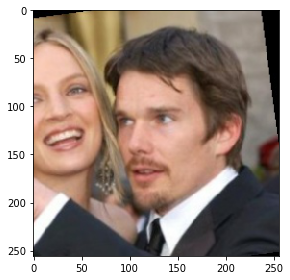

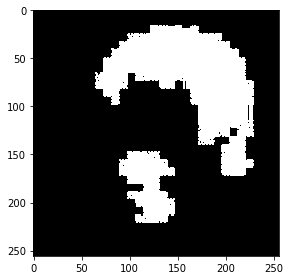

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [16]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# c10 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# c10 = Dropout(0.2) (c10)
# c10 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)
# p10 = MaxPooling2D(pool_size=(2, 2)) (c10)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
# u6 = concatenate([u6, c10])
# c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c6 = Dropout(0.2) (c6)
# c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u7 = concatenate([u7, c4])
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c3])
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c2], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)
u11 = concatenate([u11, c1], axis=3)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u11)
c11 = Dropout(0.1) (c11)
c11 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c11)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 256, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 256, 256, 16) 0           conv2d_43[0][0]                  
____________________________________________________________________________________________

In [0]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 53s 29ms/step - loss: 0.3860 - mean_iou: 0.4255 - val_loss: 0.3180 - val_mean_iou: 0.4376

Epoch 00001: val_loss improved from inf to 0.31799, saving model to model-dsbowl2018-1.h5
Epoch 2/50
1800/1800 [==============================] - 46s 25ms/step - loss: 0.2994 - mean_iou: 0.4531 - val_loss: 0.3083 - val_mean_iou: 0.4675

Epoch 00002: val_loss improved from 0.31799 to 0.30827, saving model to model-dsbowl2018-1.h5
Epoch 3/50
1800/1800 [==============================] - 45s 25ms/step - loss: 0.2801 - mean_iou: 0.4775 - val_loss: 0.3172 - val_mean_iou: 0.4853

Epoch 00003: val_loss did not improve from 0.30827
Epoch 4/50
1800/1800 [==============================] - 46s 25ms/step - loss: 0.2654 - mean_iou: 0.4912 - val_loss: 0.3153 - val_mean_iou: 0.4972

Epoch 00004: val_loss did not improve from 0.30827
Epoch 5/50
1800/1800 [==============================] - 46s 25ms/step - loss: 0

In [10]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

927/927 [==============================] - 8s 8ms/step


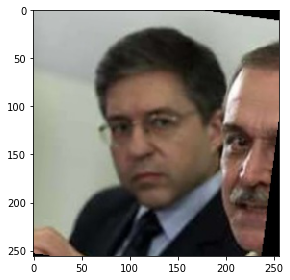

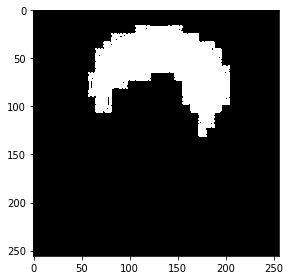

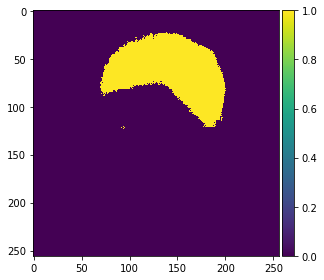

In [11]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

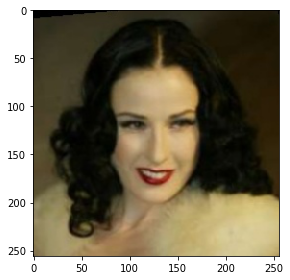

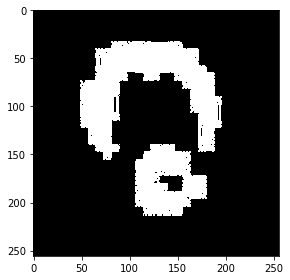

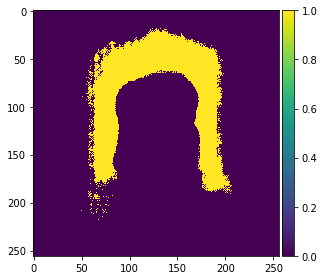

In [12]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [13]:
wfrom skimage.io import imsave
TEST_MASK_PATH = '/content/drive/My Drive/cs4990-fall2019-assignment-3/testing_masks/'
def savemask(pred):
  for i in range(len(pred)):
    files = test_ids[i].replace('img','mask')
    imsave(os.path.join(TEST_MASK_PATH,files),pred[i])
savemask(preds_test_upsampled)

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

KeyboardInterrupt: ignored

In [0]:
# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(TEST_MASK_PATH) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))

In [0]:
# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(TEST_MASK_PATH, file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))
  


In [0]:
# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('/content/drive/My Drive/cs4990-fall2019-assignment-3', '/content/drive/My Drive/cs4990-fall2019-assignment-3/assignment3_submission.csv'), index=False)